#### _Speech Processing Labs 2020: Signals 2: IIR Filters_

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import cmath
from math import floor
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.style.use('ggplot')

from dspMisc import *

# 3 Impulse Source, IIR Filter

### Learning Outcomes
* Be able to explain the difference between an FIR and an IIR filter
* Understand that IIR filters can be applied to impulse trains to produce different spectral envelopes

### Need to know
* Topic Videos: Impulse Response, Source Filter Model
* [Building the source: impulse trains](./signals-2-1-impulse-as-source.ipynb)
* [FIR filters](./signals-2-2-fir-filters.ipynb)

<div class="alert alert-warning">
<strong>Equation alert</strong>: If you're viewing this on github, please note that the equation rendering is not always perfect. You should view the notebooks through a jupyter notebook server for an accurate view.
</div>


## 3.0 Filters again

The previous notebook explored Finite Impulse Response (**FIR**) filters which took a 
 an input sequence $x[n]$ to give us some desired output sequence $y[n]$.  We saw that these FIR filters basically applied a weighted average across the input sequence and that this could be characterised in terms of convolution. 
Now, we'll look at Infinite Impulse Response (**IIR**) filters, which allow us to model more complex feedback behaviour that's closer to what we might expect from the vocal tract.

## 3.1 Definition of an Infinite Impulse Response filter

Unlike FIR filters, IIR filters use outputs from previous time steps to calculate the next output. 

$$ y[n] = \sum_{k=0}^N b[k] x[n-k] + \sum_{k=0}^M a[k] y[n-k]$$

The 'infinite' in the name comes from the fact that you can define a filter in this way so that a single impulse results in an infinitely long non-zero output sequence.  

For example

$$ y[n] =  x[n] + y[n-1] $$  

if $x[n] = 1$ for $n=1$ and 0 otherwise, then 

* $ y[1] = 1 + 0  = 1$
* $ y[2] = 0 + 1 = 1$ 
* $ y[3] = 0 + 1 = 1$  

i.e. $y[n] = 1$ for all $n$ to infinity! 

These can be much more efficient than using an FIR filter: we can get the same effect with fewer parameters. (e.g. in some cases you can define a 4th order FIR filter that does the same job as a 19th order FIR filter). The flip side is that they're harder to analyze. 

Unfortunately, there's no direct way to compute the a(k)'s and b(k)'s from the impulse response for an IIR filter, but we can use the **z Transform** to do this (we won't go into it in this class).  Instead we'll focus on how we can use an IIR filter to create a speech shaped sound.  

## 3.2 Using an IIR filter to shape the spectral envelope

### Let's start with an impulse train

Text(0.5, 1.0, 'An impulse train')

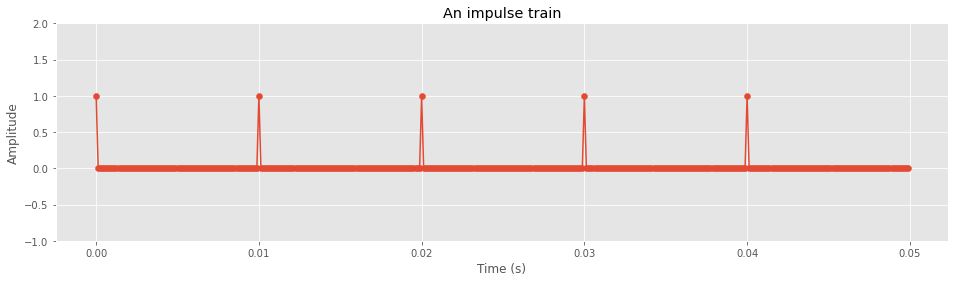

In [2]:
N=400
f_s = 8000
t_s = 1/f_s

## Set the impulse train frequency in Hz
frequency = 100

## Generate N samples of an impulse train with frequency=frequency given a sampling rate of f_s
x_imp, time_steps = make_impulse_train(sample_rate=f_s, frequency=frequency, n_samples=N)

## plot and label
fig, ax = plt.subplots(figsize=(16, 4))
ax.set(ylim=(-1, 2))
ax.scatter(time_steps, x_imp)
ax.plot(time_steps, x_imp)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.set_title("An impulse train")

### Now let's define a function to calculate the output of an IIR filter given feedback coefficients `a` and feedforward coefficients `b`.

In [3]:
# iir_filter applies the IIR filter defined by feedforward coefficients, b, and feedback coefficients, a,
# where the coefficients are input as ordered lists
def iir_filter(x, a=[], b=[]):
    
    ## Get the size of the input
    ## Note the size of N will depend on how we deal with edge cases

    N = len(x)
    
    ## Initialize our output array, y, to all zeros
    y = np.zeros(N)   
   
    ## step through each input index n
    for n in range(N):
        y[n] = 0

        ## get the contribution from the inputs
        for k in range(len(b)):
            if n-k >= 0: 
                ## multiply the previous inputs with filter coefficients, b, and add them up
                ## just like an FIR filter
                y[n] = y[n] + (b[k]*x[n-k])

        
        ## get contribution from the existing outputs        
        for l in range(len(a)):
            ## Note: We don't want to include the current output in this calculation! 

            if n-l > 0:  
                ## multiply the previous outputs with filter coefficients, a, and add them up
                y[n] = y[n] + (a[l]*y[n-l-1])

    return y    


    

### Apply the IIR filter to our impulse train


In [4]:
## An impulse train with amplified impulse to make things easier to see. 
## It doesn't change the shape of the frequency response
x = x_imp * 10

## Note coefficients opposite sign to what Simon has in his slides.  Maybe a matlab thing? 
## Or a notation thing to make transfer function look nicer? 
a = [3.22666099, -4.3967485, 3.03596532, -0.88529281]
b = [1]

## You might like to try this Low pass filter from Lyon's DSP textbook
#a=[1.194, -0.436]
#b=[0.0605, 0.121, 0.0605]

y_iir = iir_filter(x, a=a, b=b)


### Plot the filtered output in the time domain

400 92.90359312571272


Text(0.5, 1.0, 'Impulse train transformed by an IIR filter')

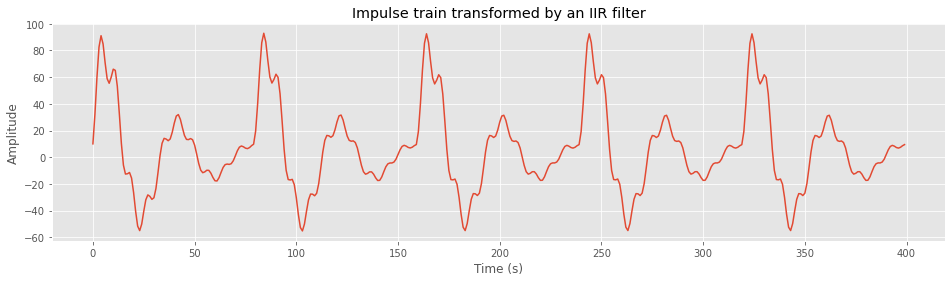

In [5]:
## Plot the filtered output
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(range(N), y_iir)
print(N, np.max(y_iir))
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.set_title("Impulse train transformed by an IIR filter")

## Starting to look more speech...ish

Now we're starting to make something that looks like a speech waveform! 

### Now let's look at the DFT of the filter's output

Text(0.5, 1.0, 'Frequency response of IIR filter output (sample rate: 8000 samples/sec)')

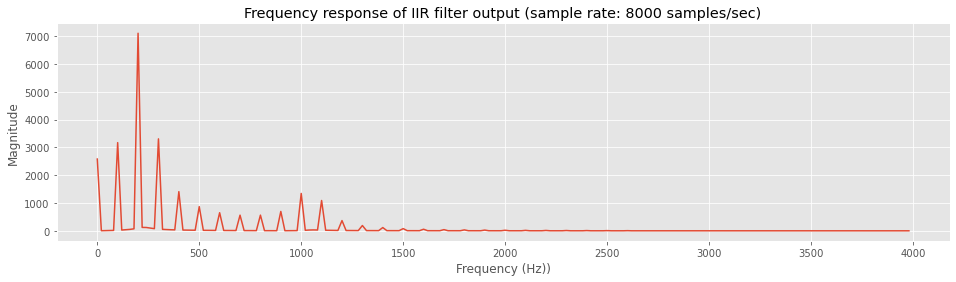

In [6]:
## Get the DFT outputs of the IIR filter's output
mags, phases = get_dft_mag_phase(y_iir, N)

## Plot the DFT frequencies rather than DFT output indices
dft_freqs = (f_s/N) * np.arange(N)

## Plot the magnitude spectrum
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(dft_freqs[0:int(N/2)], mags[0:int(N/2)])
ax.set_xlabel("Frequency (Hz))")
ax.set_ylabel("Magnitude")
ax.set_title("Frequency response of IIR filter output (sample rate: %d samples/sec)" % f_s)




### Exercise

* What happens to the filtered signal if we alter the filter coefficients:
    * Try out the filter coefficients in the cell below and describe what sort of effect they have.  
    * What sort of frequencies do they boost and which do they dampen? 
    * Do any look like low-pass or high-pass filters, for example?
    * Do all of them produce outputs that look like vocal pulses? 

* If you play around the coefficients it's quite easy to end up with an output that doesn't 'fade out' over time.  What happens to the DFT in this case?  


In [7]:
## Try out these different sets of IIR filter coefficients
## ex 1
a = [0.8]
b = [1]

## ex 2
a = [-0.8]
b = [1,-1]

## ex 3:
a = [0.566, -0.16017]
b = [1, 1.414, 1]

## ex 4: 
a = [0.566, -0.16017]
b = [1, 0.414, -0.414, -1]

## ex 5:
a = [1.272, -0.80899]
b = [1, 0.414, -0.414, -1]

## ex 6: unstable (unbounded) but still gives us a frequency response like the one previous
a = [1.554, -1.207]
b = [1, 0.414, -0.414, -1]



Text(0.5, 1.0, 'Frequency response of IIR filter output: a=[0.8], b=[1]')

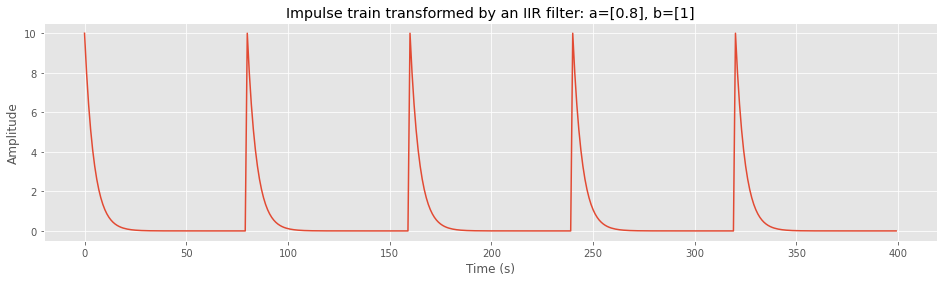

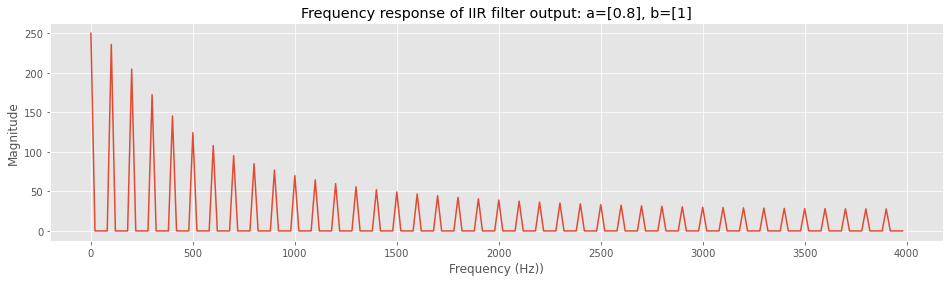

In [8]:
## set which coeffients you want to use here. 
## e.g. ex 1
a = [0.8]
b = [1]

## the impulse train
x = x_imp * 10
y_iir = iir_filter(x, a=a, b=b)

## Plot the filtered output
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(range(N), y_iir)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.set_title("Impulse train transformed by an IIR filter: a=%s, b=%s" % (repr(a), repr(b)))

#print(N, np.max(y_iir))


## Plot the DFT frequencies rather than DFT output indices
mags, phases = get_dft_mag_phase(y_iir, N)
dft_freqs = (f_s/N) * np.arange(N)

## Plot the magnitude spectrum
fig, ax = plt.subplots(figsize=(16, 4))
#ax.scatter(dft_freqs[0:int(N/2)],mags[0:int(N/2)])
ax.plot(dft_freqs[0:int(N/2)], mags[0:int(N/2)])
ax.set_xlabel("Frequency (Hz))")
ax.set_ylabel("Magnitude")
ax.set_title("Frequency response of IIR filter output: a=%s, b=%s" % (repr(a), repr(b)))





### Notes

## Want to learn more?     

If you're interested in learning more about filters or signal processing in general, it's probably time to pick up a Digital Signal Processing textbook. Rick Lyon's [Understanding Digital Signal Processing](https://www.dsprelated.com/books/6.php) is probably the most accessible I've come across. The example filters above were taken from that book. 

Previous SLP students have also recommended [The Scientist and Engineer's Guide to
Digital Signal Processing](http://www.dspguide.com/pdfbook.htm), though the free online version renders a bit weirdly!. 

You can find some derivations for the filter coefficients above [here](/signals-2-5-iir-filters-derivations.ipynb) for completeness (no, they weren't just random!).
